<h1 align="center">Level and Group Classification on Small Sample Dataset</h1>

We have two classification tasks:

* Predict the level, which ranges from 1-16.
* Predict the group of a given text, given this mapping from levels to group:
  - Levels 1-3 = Group A1
  - Levels 4-6 = Group A2
  - Levels 7-9 = Group B1
  - Levels 10-12 = Group B2
  - Levels 13-15 = Group C1
  - Levels 16 = Group C2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

# Map Level to Group

Here we load the saved pickle file containing the DataFrame for the entire dataset. Then we map the `level` column to `group` so we have the target labels for both classification tasks.`

In [2]:
raw_input = pd.read_pickle('input.pkl')

gp_mapper = {
    1: 'A1', 2: 'A1', 3: 'A1',
    4: 'A2', 5: 'A2', 6: 'A2',
    7: 'B1', 8: 'B1', 9: 'B1',
    10: 'B2', 11: 'B2', 12: 'B2',
    13: 'C1', 14: 'C1', 15: 'C1',
    16: 'C2'
}

raw_input = raw_input.assign(group=raw_input.level.map(gp_mapper))    

In [3]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180309 entries, 0 to 1180308
Data columns (total 8 columns):
article_id    1180309 non-null int64
grade         1180309 non-null int64
level         1180309 non-null int64
text          1180309 non-null object
topic_id      1180309 non-null int64
topic_text    1180309 non-null object
unit          1180309 non-null int64
group         1180309 non-null object
dtypes: int64(5), object(3)
memory usage: 72.0+ MB


In [4]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit,group
0,1,90,6,"After some time, the affection between them is...",41,Writing a movie plot,1,A2
1,2,90,6,An e-ticket is a provement that you bought the...,42,Filling in an arrival card,2,A2
2,3,86,6,From:xxx@1234.com To:Herman xxx@1234.com Date:...,43,Creating an office dress code,3,A2
3,4,87,1,"Hi Anna ,How are you . My name's Jayla . My te...",1,Introducing yourself by email,1,A1
4,5,95,1,"Dear Ms Thomas, There are thirty pens and fift...",2,Taking inventory in the office,2,A1


# Train-test Split

Here, we split the raw input into train (80%) and test (20%) sets. From the train set, we take 1000 samples for each level to construct a small sample dataset that we can experiment quickly on.

In [5]:
from sklearn.model_selection import train_test_split

# Split the index of `raw_input` DataFrame into train and test and the use the to split the DataFrame.
train_idx, test_idx = train_test_split(    
    raw_input.index, 
    test_size=0.2,
    stratify=raw_input.level, 
    shuffle=True,
    random_state=0)

train_df, test_df = raw_input.loc[train_idx], raw_input.loc[test_idx]
train_df.to_pickle('train_full.pkl')
test_df.to_pickle('test.pkl')

# Small sample Dataset from train set using 1000 elements per level
train_df_small = train_df.groupby('level').apply(lambda g: g.sample(n=1000, replace=False, random_state=1234))
train_df_small.index = train_df_small.index.droplevel(0)

train_df_small.to_pickle('train_small.pkl')

For the rest of this notebook, we use the small sample dataset as input.

In [6]:
raw_input = pd.read_pickle('train_small.pkl')

# Check for Class Imbalance

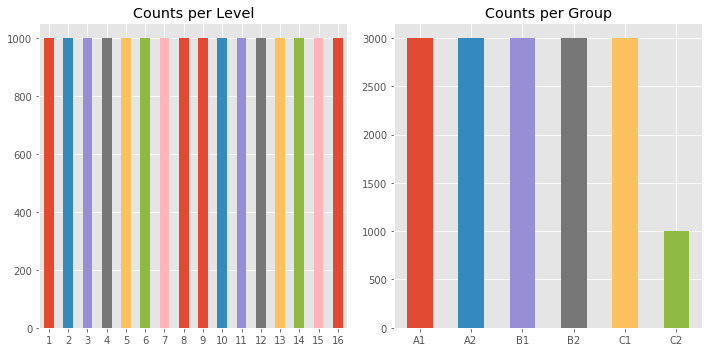

In [7]:
level_counts = raw_input.level.value_counts().sort_index()
group_counts = raw_input.group.value_counts().sort_index()

_, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = level_counts.plot(kind='bar', title='Counts per Level', ax=ax[0], rot=0)
_ = group_counts.plot(kind='bar', title='Counts per Group', ax=ax[1], rot=0)

plt.tight_layout()

# Level Classification Based on Text

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(en_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'weren', "should've", 'or', 'such', 'into', 's', 'when', 'during', 'why', 'under', 'until', 'just', "doesn't", 'him', 'y', 'doesn', 't', 'both', 'shan', 'yours', 'our', 'mustn', 'yourself', 'now', 'has', 'haven', 'about', 'ain', 'you', 'any', 'and', 'll', 'too', 'here', 'very', 'down', 'these', 'were', 'does', 'between', 'myself', 'for', 'only', 'again', 'should', "haven't", 'o', 'he', 'each', 'up', 'being', 'is', 'hadn', 'she', 'after', 're', 'i', 'we', "don't", 'herself', 'not', 'couldn', 'had', 'than', 'if', 'won', 'yourselves', 'did', 'will', 'am', 'that', "won't", 'been', 'whom', 'this', "hadn't", 'how', 'isn', 'through', 'most', "wasn't", 'them', 'at', 'which', 'have', 'because', 'hasn', 'me', 'her', "needn't", 'a', 'ot

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold


def classify_v1(input_df, target_label='level'):
    """
    Build a classifier for the `target_label` column in the DataFrame `input_df` using the `text` column.    
    Return the (labels, predicted_labels) tuple.    
    Use a 10-fold Stratified K-fold cross-validator to generate the out-of-sample predictions."""
    
    assert target_label in input_df.columns
    
    counter = TfidfVectorizer(
        ngram_range=(1, 2), 
        stop_words=en_stopwords, 
        max_df=0.4, 
        min_df=25, 
        max_features=3000, 
        sublinear_tf=True
    )

    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression(penalty='l2', max_iter=200, random_state=4321)
    pipeline = make_pipeline(counter, scaler, model)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

    X = raw_input.text
    y = raw_input.level
    y_pred = cross_val_predict(pipeline, X=X.values, y=y.values, cv=cv, n_jobs=16, verbose=2)
    y_pred = pd.Series(index=raw_input.index.copy(), data=y_pred)
    
    return y.copy(), y_pred

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def display_results(y, y_pred):
    """Given some predications y_pred for a target label y, 
    display the precision/recall/f1 score and the confusion matrix."""
        
    report = classification_report(y_pred, y)
    print(report)

    level_values = y.unique()
    level_values.sort()
    cm = confusion_matrix(y_true=y, y_pred=y_pred.values, labels=level_values)
    cm = pd.DataFrame(index=level_values, columns=level_values, data=cm)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, ax=ax, fmt='d')

[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    9.9s remaining:   23.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   10.3s finished


             precision    recall  f1-score   support

          1       0.90      0.89      0.90      1007
          2       0.89      0.88      0.88      1019
          3       0.85      0.88      0.87       972
          4       0.86      0.85      0.85      1010
          5       0.86      0.87      0.87       993
          6       0.88      0.91      0.90       966
          7       0.81      0.81      0.81      1000
          8       0.80      0.78      0.79      1025
          9       0.82      0.82      0.82       999
         10       0.85      0.87      0.86       978
         11       0.77      0.76      0.76      1023
         12       0.86      0.87      0.87       996
         13       0.91      0.90      0.90      1013
         14       0.86      0.86      0.86      1002
         15       0.81      0.80      0.80      1010
         16       0.85      0.86      0.86       987

avg / total       0.85      0.85      0.85     16000

CPU times: user 332 ms, sys: 252 ms, total:

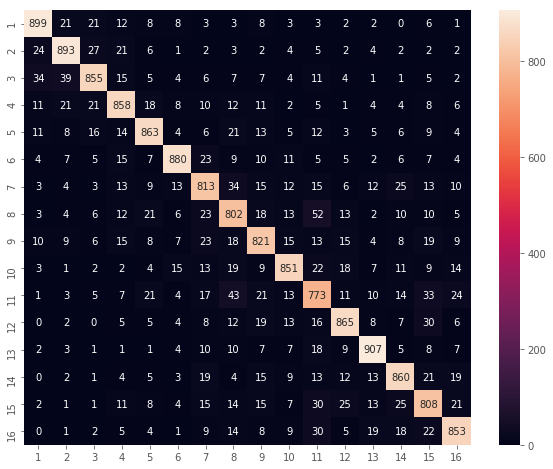

In [11]:
%%time
levels, levels_predicted = classify_v1(raw_input, target_label='level')
display_results(levels, levels_predicted)

# Misclassifications

Here we look at the misclassified samples to try to understand why the tf-idf model doesn't work for them.

In [12]:
# assign the predicated level as a column to the input data
input_with_preds = raw_input.assign(level_predicted=levels_predicted)
input_with_preds.head()

,article_id,grade,level,text,topic_id,topic_text,unit,group,level_predicted
1173026,1203917,95,1,My boss is fritndly. He's not tall. He's blak ...,4,Describing your family in an email,4,A1,1
372246,380077,82,1,"hello teacher, i'm zm i leran english is may d...",1,Introducing yourself by email,1,A1,8
581426,594588,100,1,"Hello, my name is Paola Ramirez, nice to meet ...",1,Introducing yourself by email,1,A1,1
887725,909797,90,1,My office is smaller. so there are some desks ...,2,Taking inventory in the office,2,A1,1
473101,483238,93,1,Hi. My name's Vladimir Budiyan. My phone's num...,1,Introducing yourself by email,1,A1,1


We can identify the misclassified examples by the condition

    input_with_preds.level != input_with_preds.level_predicted
    
For these rows, we want to identify the pair ('level', 'level_predicted') that produces the greatest number of mismatches, because addressing these will produce the biggest improvement in the overall score.

In [13]:
misclassifications = input_with_preds[input_with_preds.level != input_with_preds.level_predicted]
m_counts = misclassifications.groupby(by=['level', 'level_predicted'])['text'].count()
m_counts.sort_values(ascending=False).head(8)

level  level_predicted
8      11                 52
11     8                  43
3      2                  39
7      8                  34
3      1                  34
11     15                 33
12     15                 30
16     11                 30
Name: text, dtype: int64

As an example, we investigate the misclassifications between levels 7 and 8.

In [23]:
cond = (misclassifications.level.isin([7, 8])) & (misclassifications.level_predicted.isin([7, 8]))
mis_sample = misclassifications.loc[cond, ['topic_text', 'topic_id', 'text', 'level', 'level_predicted']]
mis_sample.groupby(['topic_id', 'topic_text', 'level', 'level_predicted'])['text'].count().sort_values(ascending=False)

topic_id  topic_text                             level  level_predicted
50        Planning for the future                7      8                  21
59        Making a 'to do' list of your dreams   8      7                  10
62        Responding to written invitations      8      7                   5
60        Describing a business trip             8      7                   4
52        Writing about a memorable experience   7      8                   4
54        Issuing a written warning              7      8                   3
57        Writing a natural remedies pamphlet    8      7                   2
56        Posting comments on a celebrity forum  7      8                   2
49        Giving instructions to play a game     7      8                   2
61        Selling items in an online auction     8      7                   1
58        Reviewing a song for a website         8      7                   1
55        Writing a letter of complaint          7      8             

So, most of the misclassifications for true level 7 occur for the topic "Planning for the future", whereas for level 8, it is 
"Making a 'to do' list of your dreams". Intuitively, this makes sense. These two topics are similar, so the word frequency distributions could very well be similar.

Next we extract wordcount tf-idf matrices for a subset of these articles and compare different aspects of them.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def calc_bow_matrix_for_topic_id(df, topic_id, limit=5):
    """Return a dense DataFrame of Word counts with words as index, article IDs as columns."""
    all_texts = df[df.topic_id == topic_id].text.head(limit)

    cv = CountVectorizer(stop_words=en_stopwords)
    t = cv.fit_transform(all_texts.values)
    words = cv.get_feature_names()

    tf_idf_matrix = pd.DataFrame(index=all_texts.index.copy(), columns=words, data=t.todense()).T
    return tf_idf_matrix

tid_50, tid_59 = map(lambda x: calc_bow_matrix_for_topic_id(mis_sample, x), [50, 59])

In [25]:
tid_50.head(20)

,833884,1145833,871956,743942,957863
actually,0,0,0,0,1
adriana,0,0,1,0,0
almost,0,0,0,0,1
already,0,1,0,0,0
also,0,0,0,1,0
always,0,0,1,0,0
audi,0,0,0,1,0
automotive,0,0,0,1,0
beautiful,0,0,1,0,0
becoming,0,1,0,0,0


In [26]:
tid_59.head(20)

,640893,617795,257076,50733,1860
academy,0,1,0,0,0
actual,0,1,0,0,0
adventurous,0,0,0,1,0
although,0,1,0,0,0
always,0,0,0,1,0
another,0,0,1,0,0
apply,1,0,0,0,0
arabic,0,0,1,0,0
art,0,1,0,0,0
belly,0,0,1,0,0


In [27]:
uncommon_words = tid_50.index.symmetric_difference(tid_59.index).tolist()
print(uncommon_words)

['academy', 'actual', 'actually', 'adriana', 'adventurous', 'almost', 'already', 'also', 'although', 'another', 'apply', 'arabic', 'art', 'audi', 'automotive', 'beautiful', 'becoming', 'belly', 'books', 'bring', 'brother', 'brothers', 'bungee', 'bus', 'business', 'bussiness', 'came', 'cat', 'change', 'choice', 'city', 'classical', 'concrete', 'continue', 'country', 'course', 'culture', 'curious', 'customers', 'dad', 'daily', 'dance', 'dancer', 'daughter', 'day', 'days', 'de', 'dear', 'decide', 'developing', 'difficult', 'doctor', 'dreaming', 'driver', 'east', 'eg', 'email', 'etc', 'european', 'everything', 'exam', 'example', 'exchange', 'famous', 'far', 'fever', 'find', 'finish', 'first', 'food', 'freelance', 'friend', 'front', 'futur', 'ge', 'germany', 'getting', 'girlfriend', 'group', 'hello', 'help', 'hi', 'holiday', 'hoping', 'hospital', 'hours', 'important', 'intend', 'intent', 'internet', 'janeiro', 'join', 'jumping', 'kiss', 'kisses', 'knowing', 'language', 'languages', 'learnin

So the word count matrix is extremely sparse and a fair amount of words only appear in one set of articles and not the other. Based on that, I concluded that the presence / absence of rare words could be a better indicator of level instead of tf-idf. 

Next we re-run the model evaluation step using binary valued features indicating presence / absence.

# Improving the Model

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold


def classify_v2(input_df, target_label='level'):
    """
    Build a classifier for the `target_label` column in the DataFrame `input_df` using the `text` column.    
    Return the (labels, predicted_labels) tuple.    
    Use a 10-fold Stratified K-fold cross-validator to generate the out-of-sample predictions."""
    
    assert target_label in input_df.columns
    
    counter = CountVectorizer(
        lowercase=True, 
        stop_words=en_stopwords, 
        ngram_range=(1, 1),        
        min_df=5,
        max_df=0.4,
        binary=True)

    model = LogisticRegression(
        penalty='l2', 
        max_iter=200, 
        multi_class='multinomial', 
        solver='lbfgs', 
        verbose=True,
        random_state=4321)
    
    pipeline = make_pipeline(counter, model)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

    X = input_df.text
    y = input_df.loc[:, target_label]
    y_pred = cross_val_predict(pipeline, X=X.values, y=y.values, cv=cv, n_jobs=10, verbose=2)
    y_pred = pd.Series(index=raw_input.index.copy(), data=y_pred)

    return y.copy(), y_pred

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   29.5s remaining:  1.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s finished
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   30.2s finished


             precision    recall  f1-score   support

          1       0.94      0.86      0.90      1098
          2       0.90      0.87      0.89      1036
          3       0.90      0.87      0.89      1029
          4       0.89      0.87      0.88      1020
          5       0.89      0.87      0.88      1023
          6       0.91      0.89      0.90      1023
          7       0.86      0.86      0.86       996
          8       0.83      0.83      0.83       997
          9       0.88      0.85      0.87      1025
         10       0.87      0.90      0.88       963
         11       0.81      0.81      0.81      1000
         12       0.86      0.88      0.87       974
         13       0.88      0.92      0.90       960
         14       0.87      0.89      0.88       971
         15       0.79      0.85      0.82       933
         16       0.86      0.90      0.88       952

avg / total       0.87      0.87      0.87     16000

CPU times: user 344 ms, sys: 236 ms, total:

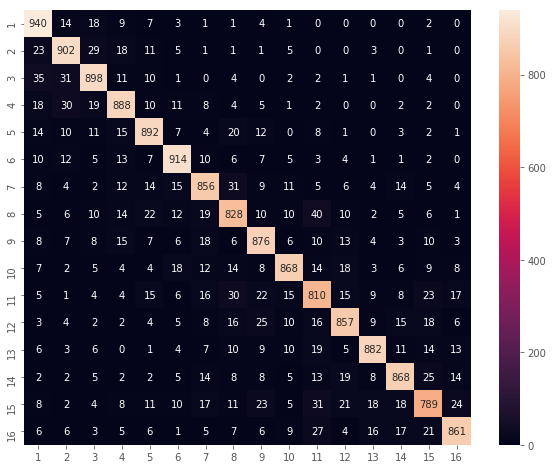

In [30]:
%%time
levels, levels_predicted = classify_v2(raw_input, target_label='level')
display_results(levels, levels_predicted)

Using binary features the composite f1-score has improved to **0.87** from **0.85**.

# Group Classification Based on Text

This is essentially the same classification problem as the `level` classification but with collapsed categories, so my intuition is that the same feature-classifier combination will work well and should produce slightly better performance.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   21.0s remaining:   48.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s finished
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   22.4s finished


             precision    recall  f1-score   support

         A1       0.96      0.92      0.94      3140
         A2       0.90      0.89      0.90      3020
         B1       0.87      0.86      0.86      3037
         B2       0.87      0.87      0.87      2983
         C1       0.87      0.88      0.88      2965
         C2       0.81      0.94      0.87       855

avg / total       0.89      0.89      0.89     16000

CPU times: user 380 ms, sys: 228 ms, total: 608 ms
Wall time: 22.9 s


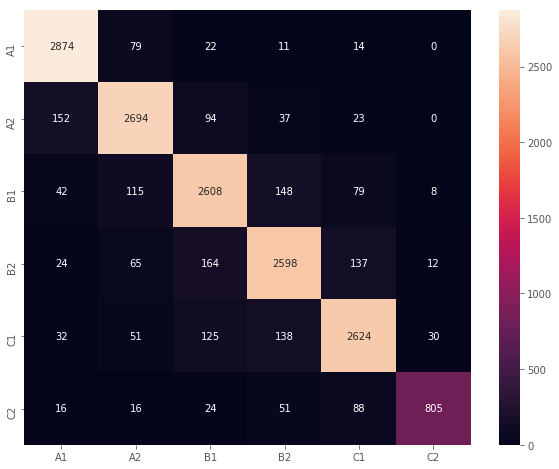

In [31]:
%%time

groups, groups_predicted = classify_v2(raw_input, target_label='group')
display_results(groups, groups_predicted)